### Question: If we don't normalise do we get all from HVAC for active learning

In [1]:
import autograd.numpy as np
from autograd import grad
import pandas as pd
import sys
import matplotlib.pyplot as plt
%matplotlib inline

#### Loading the dataset

In [2]:
d = np.load("/Users/nipun/Downloads/data-2013-2017-missing.npy").item()

#### Finding homes occuring across both years

In [3]:
np.intersect1d(list(d[2016].keys()), list(d[2015].keys())).size

214

In [4]:
np.intersect1d(list(d[2017].keys()), list(d[2016].keys())).size

153

I would be choosing 2015 and 2016 as the successive years

In [5]:
use_homes = np.intersect1d(list(d[2016].keys()), list(d[2015].keys()))

In [6]:
use_homes

array([  26,   59,   77,   86,   93,   94,  101,  114,  187,  434,  484,
        499,  503,  545,  624,  744,  781,  871,  946,  974, 1086, 1103,
       1169, 1192, 1202, 1283, 1403, 1415, 1463, 1500, 1507, 1589, 1617,
       1632, 1642, 1697, 1700, 1718, 1790, 1800, 1953, 2018, 2094, 2129,
       2156, 2171, 2199, 2233, 2365, 2378, 2472, 2532, 2557, 2575, 2638,
       2755, 2787, 2814, 2818, 2829, 2859, 2945, 2953, 2965, 3009, 3039,
       3044, 3134, 3268, 3310, 3367, 3392, 3456, 3482, 3500, 3527, 3538,
       3577, 3649, 3778, 3829, 3831, 3849, 3916, 3918, 3935, 3967, 4031,
       4154, 4213, 4220, 4297, 4298, 4336, 4342, 4352, 4357, 4373, 4375,
       4473, 4514, 4641, 4767, 4874, 4946, 4957, 4998, 5026, 5060, 5129,
       5218, 5275, 5317, 5357, 5403, 5545, 5568, 5677, 5718, 5785, 5809,
       5814, 5874, 5889, 5921, 5949, 5959, 5972, 6061, 6063, 6121, 6139,
       6165, 6348, 6412, 6423, 6460, 6498, 6691, 6692, 6730, 6990, 7016,
       7030, 7361, 7390, 7429, 7504, 7536, 7560, 76

In [7]:
APPLIANCE_ORDER = ['use', 'air1', 'clotheswasher1', 'drye1', 'furnace1', 'kitchenapp1',
       'microwave1', 'refrigerator1']

### Creating the tensor data

In [8]:
t = np.empty((len(use_homes), len(APPLIANCE_ORDER), 2*12))

In [9]:
t[:] = np.NaN

In [10]:
for i, home in enumerate(use_homes):
    for j, appliance in enumerate(APPLIANCE_ORDER):
        try:
            t[i, j, :12] = d[2016][home][appliance].values
            t[i, j, 12:] = d[2017][home][appliance].values
        except:
            pass

In [11]:
t.shape

(214, 8, 24)

### STF routine

In [12]:
def factorise(tensor, r, random_seed=0, num_iter=400, eps=1e-8, lr=1):
    np.random.seed(random_seed)
    args_num = [1, 2, 3]

    def cost(tensor, home, appliance,  month):
        pred = np.einsum('Hr, Ar, Tr ->HAT', home, appliance, month)
        mask = ~np.isnan(tensor)
        error = (pred - tensor)[mask].flatten()
        return np.sqrt((error ** 2).mean())

    mg = grad(cost, argnum=args_num)
    sizes = [(x, r) for x in tensor.shape]
    home = np.random.rand(*sizes[0])
    appliance = np.random.rand(*sizes[1])
    month = np.random.rand(*sizes[2])

    sum_home = np.zeros_like(home)
    sum_appliance = np.zeros_like(appliance)
    sum_month = np.zeros_like(month)

    # GD procedure
    for i in range(num_iter):
        del_home, del_appliance, del_month = mg(tensor, home, appliance, month)

        sum_home += eps + np.square(del_home)
        lr_home = np.divide(lr, np.sqrt(sum_home))
        home -= lr_home * del_home

        sum_appliance += eps + np.square(del_appliance)
        lr_appliance = np.divide(lr, np.sqrt(sum_appliance))
        appliance -= lr_appliance * del_appliance

        sum_month += eps + np.square(del_month)
        lr_month = np.divide(lr, np.sqrt(sum_month))
        month -= lr_month * del_month

        
        # Projection to non-negative space
        home[home < 0] = 1e-8
        appliance[appliance < 0] = 1e-8
        month[month < 0] = 1e-8

        if i % 500 == 0:
            #print(cost(tensor, home, appliance, month), i)
            sys.stdout.flush()

    return home, appliance, month

#### Creating the different subsets if data

In [13]:
# Test is last 44 homes
test_set = t[170:].copy()
# In test set, we don't know the appliance data
test_set[:, 1:, :] = np.NaN
# Train + Pool is the remaining set
train_pool_set = t[:170].copy()
# Initial train set is 10 homes
train_set = t[:10].copy()
# Initial pool set is 10-170 homes
pool_set = t[10:170].copy()
pool_homes = use_homes[10:170]
# Train + Test set (useful for factorisation)
train_test_set = np.vstack([train_set, test_set])

### Creating the set of (home, appliance) pairs for each month that can contain data and thus can be used for acquiring labels

In [14]:
p_m_h = {}
for month in range(12, 24):
    p_m_h[month] = []
    for home in pool_homes:
        for i, appliance in enumerate(APPLIANCE_ORDER[1:]):
            pool_home_index  = np.searchsorted(use_homes, home)
            if np.isfinite(t[pool_home_index, i+1, month]):
                p_m_h[month].append((home, appliance))

In [15]:
pool_homes

array([ 484,  499,  503,  545,  624,  744,  781,  871,  946,  974, 1086,
       1103, 1169, 1192, 1202, 1283, 1403, 1415, 1463, 1500, 1507, 1589,
       1617, 1632, 1642, 1697, 1700, 1718, 1790, 1800, 1953, 2018, 2094,
       2129, 2156, 2171, 2199, 2233, 2365, 2378, 2472, 2532, 2557, 2575,
       2638, 2755, 2787, 2814, 2818, 2829, 2859, 2945, 2953, 2965, 3009,
       3039, 3044, 3134, 3268, 3310, 3367, 3392, 3456, 3482, 3500, 3527,
       3538, 3577, 3649, 3778, 3829, 3831, 3849, 3916, 3918, 3935, 3967,
       4031, 4154, 4213, 4220, 4297, 4298, 4336, 4342, 4352, 4357, 4373,
       4375, 4473, 4514, 4641, 4767, 4874, 4946, 4957, 4998, 5026, 5060,
       5129, 5218, 5275, 5317, 5357, 5403, 5545, 5568, 5677, 5718, 5785,
       5809, 5814, 5874, 5889, 5921, 5949, 5959, 5972, 6061, 6063, 6121,
       6139, 6165, 6348, 6412, 6423, 6460, 6498, 6691, 6692, 6730, 6990,
       7016, 7030, 7361, 7390, 7429, 7504, 7536, 7560, 7627, 7641, 7719,
       7731, 7769, 7787, 7788, 7793, 7850, 7875, 79

In [16]:
np.searchsorted(use_homes, 484)

10

In [17]:
t[11, :, 12:]

array([[1081.96350098,  949.75939941,  961.7890625 , 1078.99035645,
        1111.97912598, 1712.67407227, 2093.8984375 , 1828.70056152,
        1437.41906738, 1172.37854004, 1099.13476562, 1473.79321289],
       [   0.        ,    0.        ,    8.12929058,   82.02701569,
         180.28712463,  565.4019165 ,  853.81469727,  702.6651001 ,
         448.10568237,  165.92414856,   77.59373474,    8.57880783],
       [          nan,           nan,           nan,           nan,
                  nan,           nan,           nan,           nan,
                  nan,           nan,           nan,           nan],
       [          nan,           nan,           nan,           nan,
                  nan,           nan,           nan,           nan,
                  nan,           nan,           nan,           nan],
       [  55.91287994,   24.40205765,   12.84283447,   26.66916656,
          53.20463562,  150.69319153,  217.98664856,  188.46160889,
         123.95488739,   50.21839142,   36.5

In [18]:
p_m_h[12]

[(499, 'air1'),
 (499, 'furnace1'),
 (499, 'kitchenapp1'),
 (499, 'refrigerator1'),
 (503, 'air1'),
 (503, 'furnace1'),
 (503, 'kitchenapp1'),
 (503, 'microwave1'),
 (503, 'refrigerator1'),
 (744, 'air1'),
 (781, 'air1'),
 (781, 'clotheswasher1'),
 (781, 'drye1'),
 (781, 'furnace1'),
 (781, 'kitchenapp1'),
 (781, 'microwave1'),
 (781, 'refrigerator1'),
 (871, 'air1'),
 (871, 'clotheswasher1'),
 (871, 'drye1'),
 (871, 'furnace1'),
 (871, 'kitchenapp1'),
 (871, 'microwave1'),
 (871, 'refrigerator1'),
 (974, 'air1'),
 (974, 'drye1'),
 (1086, 'air1'),
 (1086, 'furnace1'),
 (1086, 'microwave1'),
 (1086, 'refrigerator1'),
 (1103, 'air1'),
 (1103, 'clotheswasher1'),
 (1169, 'air1'),
 (1169, 'clotheswasher1'),
 (1169, 'drye1'),
 (1169, 'furnace1'),
 (1169, 'kitchenapp1'),
 (1169, 'microwave1'),
 (1169, 'refrigerator1'),
 (1192, 'air1'),
 (1192, 'clotheswasher1'),
 (1192, 'drye1'),
 (1202, 'air1'),
 (1202, 'furnace1'),
 (1415, 'air1'),
 (1415, 'clotheswasher1'),
 (1415, 'drye1'),
 (1415, 'furna

#### Randomly adding 5 homes every month from Pool

In [20]:
pred_df_random = {}
from copy import deepcopy
pool_r_random = {}
for seed in range(10):
    pool_r_random[seed] = {}
    print("*-*-*"*20)
    print(seed)
    pool_use = np.empty((0, len(APPLIANCE_ORDER), 24))
    pool_set_iter = deepcopy(p_m_h)
    pred_df_random[seed] = {}
    pool_remove_ix = {}
    pool_remove = {}
    gt_df = {}

    for cur_iteration, month in enumerate(range(12, 24)):
        np.random.seed(seed)
        # Randomly choose `n` to remove from pool and put in training set
        pool_remove_ix[cur_iteration] = np.random.choice(range(len(pool_set_iter[month])), size=5)
        pool_remove[month] = [pool_set_iter[month][x] for x in pool_remove_ix[cur_iteration]]

        # Remove these from future months pool too
        for month_f in range(month+1, 24):
            for x in pool_remove[month]:
                if x in pool_set_iter[month_f]:
                    pool_set_iter[month_f].remove(x)


        # Getting data from `t` to create the pool_use_set
        pool_remove_homes = [x[0] for x in pool_remove[month]]
        pool_remove_homes_ix = np.searchsorted(use_homes, pool_remove_homes)

        cur_pool = t[pool_remove_homes_ix, :, :].copy()
        # All past data is unknown
        cur_pool[:, 1:, :month] = np.NaN

        # All future data for all appliances except the chosen one is known
        cur_pool[:, 1:, month:] = np.NaN
        for q, h in enumerate(pool_remove_homes_ix):
            appliance_num = APPLIANCE_ORDER.index(pool_remove[month][q][1])
            cur_pool[q, appliance_num, month:] = t[h, appliance_num, month:]

        pool_use = np.concatenate([pool_use, cur_pool])

        pool_train_test = np.concatenate([pool_use, train_test_set[:, :, :] ])

        h, a, m =factorise(pool_train_test[:, :, :month], 3)
        print(cur_iteration, month, len(pool_train_test), pool_remove[month])

        pred = np.einsum('Hr, Ar, Tr ->HAT', h, a, m)
        pred_df_random[seed][month] = pred[len(train_set)+len(pool_use):,1:, month-1:month].reshape(-1, len(APPLIANCE_ORDER)-1)
        gt_df[month] = t[170:][:, 1:, month-1:month].reshape(len(test_set), len(APPLIANCE_ORDER)-1)
    pool_r_random[seed] = deepcopy(pool_remove)

*-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-*
0
0 12 59 [(3849, 'clotheswasher1'), (1415, 'furnace1'), (2859, 'microwave1'), (4336, 'air1'), (7504, 'drye1')]
1 13 64 [(3849, 'microwave1'), (1415, 'kitchenapp1'), (2953, 'air1'), (4357, 'drye1'), (7560, 'microwave1')]
2 14 69 [(3967, 'clotheswasher1'), (1415, 'microwave1'), (2953, 'drye1'), (4375, 'microwave1'), (7627, 'furnace1')]
3 15 74 [(3967, 'refrigerator1'), (1415, 'refrigerator1'), (2965, 'air1'), (4514, 'drye1'), (7641, 'clotheswasher1')]
4 16 79 [(4213, 'furnace1'), (1500, 'air1'), (2965, 'drye1'), (4946, 'air1'), (7641, 'refrigerator1')]
5 17 84 [(4297, 'air1'), (1500, 'furnace1'), (2965, 'kitchenapp1'), (4946, 'microwave1'), (7769, 'drye1')]
6 18 89 [(4298, 'furnace1'), (1500, 'kitchenapp1'), (2965, 'refrigerator1'), (4998, 'furnace1'), (7788, 'drye1')]
7 19 94 [(4336, 'drye1'), (1500, 'microwave1'), (3009, 'drye1'), (5026, 'air1'), (7850, 'drye1')]
8 20 99 [(4375, 'cloth

8 20 99 [(8046, 'kitchenapp1'), (5317, 'furnace1'), (4946, 'refrigerator1'), (3009, 'drye1'), (2156, 'furnace1')]
9 21 104 [(8059, 'furnace1'), (5545, 'air1'), (4998, 'kitchenapp1'), (3134, 'drye1'), (2156, 'microwave1')]
10 22 109 [(8079, 'kitchenapp1'), (5545, 'microwave1'), (5026, 'clotheswasher1'), (3310, 'drye1'), (2156, 'refrigerator1')]
11 23 114 [(5809, 'clotheswasher1'), (5218, 'microwave1'), (3367, 'clotheswasher1'), (2171, 'air1'), (503, 'refrigerator1')]
*-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-**-*-*
6
0 12 59 [(8046, 'air1'), (4375, 'refrigerator1'), (5218, 'furnace1'), (2814, 'air1'), (7850, 'kitchenapp1')]
1 13 64 [(8046, 'refrigerator1'), (4514, 'clotheswasher1'), (5218, 'refrigerator1'), (2814, 'clotheswasher1'), (7875, 'clotheswasher1')]
2 14 69 [(8059, 'kitchenapp1'), (4514, 'furnace1'), (5275, 'furnace1'), (2814, 'drye1'), (7900, 'air1')]
3 15 74 [(8079, 'kitchenapp1'), (4514, 'refrigerator1'), (5275, 'refrigerat

In [21]:
r = {}
for j in range(10):
    
    y = list(pool_r_random[j].values())
    r[j] = {}
    for p in range(5, 65, 5):
        r[j][p] = pd.Series([z[1] for x in y for z in x]).head(p).value_counts()
        

In [22]:
pd.Panel(r).mean(axis=0)

/Users/nipun/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  exec(code_obj, self.user_global_ns, self.user_ns)


,5,10,15,20,25,30,35,40,45,50,55,60
air1,1.428571,2.500000,3.500000,4.600000,6.200000,7.500000,7.900000,9.5,10.7,11.8,12.9,14.2
clotheswasher1,1.200000,2.000000,2.700000,3.400000,3.900000,4.100000,5.300000,6.1,6.9,7.3,8.1,8.7
drye1,1.600000,2.200000,2.714286,2.777778,3.400000,3.900000,4.500000,5.4,6.0,6.9,7.3,8.1
furnace1,1.142857,1.200000,2.000000,2.700000,3.300000,4.300000,5.500000,5.9,6.5,7.4,8.3,8.7
kitchenapp1,1.500000,1.333333,1.500000,1.600000,1.833333,2.166667,2.111111,2.3,2.8,3.2,4.0,4.7
microwave1,1.600000,2.000000,2.555556,3.222222,3.200000,4.000000,4.400000,4.7,5.0,5.5,6.1,6.9
refrigerator1,1.750000,2.000000,2.222222,3.100000,3.900000,4.900000,5.500000,6.1,7.1,7.9,8.3,8.7


/Users/nipun/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  exec(code_obj, self.user_global_ns, self.user_ns)


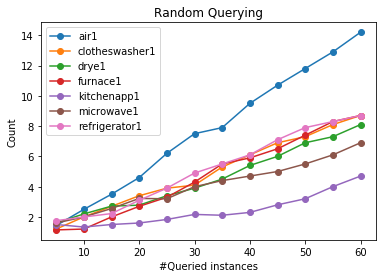

In [23]:
pd.DataFrame(pd.Panel(r).mean(axis=0)).T.fillna(0).plot(marker='o')
plt.xlabel("#Queried instances")
plt.ylabel("Count")
plt.title("Random Querying")
plt.savefig("active-random-instances.pdf")
plt.savefig("active-random-instances.png")

### Active learning Testing

In [ ]:
pool_use = np.empty((0, 7, 24))
gt_df = {}
pred_df_active = {}
pool_remove_active = {}
pool_set_active = {}
all_seen = []

for cur_iteration, month in enumerate(range(12, 13)):
    

    pred_pool = {}
    psc = pool_set.copy()
    psc[:, 1:, :] = np.NaN
    month_contri = (pd.DataFrame(train_set[:, :, month]).mean()/pd.DataFrame(train_set[:, :, month]).mean()[0]).drop(0).to_dict()
    # Starting with current data and finding the variance amongst different #Latent factors
    for r in range(2, 8):
        print(month, r)
        pool_train = np.concatenate([psc, train_set[:, :, :] ])
        h, a, m =factorise(pool_train[:, :, :month], r)
        # This gives us prediction on the pool set only
        pred_pool[r] = np.einsum('Hr, Ar, Tr ->HAT', h, a, m)[:len(pool_set)]
   

### Variance 

In [ ]:
pd.DataFrame({x:pred_pool[x][:, 1, -1] for x in range(2, 8)}).std(axis=1).sort_values()

In [ ]:
# Finding the top-most `n` highly variance homes
# measure = std/contri
temp = []
for appliance_num, appliance in enumerate(APPLIANCE_ORDER[1:]):
    y = pd.DataFrame({r:pd.Series(pred_pool[r][:, appliance_num+1, -1])for r in range(2, 8)}).std(axis=1)
    y.index = [(x, appliance) for x in pool_homes]
    #y = (y - y.min())/(y.max()-y.min())
    temp.append(y)

print(pd.concat(temp).sort_values(ascending=False).drop(all_seen).head(50))

In [ ]:
pool_remove_active[month] = pd.concat(temp).sort_values(ascending=False).drop(all_seen).head(5).index.tolist() 

all_seen.extend(pool_remove_active[month])
all_seen = list(set(all_seen))

# Getting data from `t` to create the pool_use_set
pool_remove_homes_active = [x[0] for x in pool_remove_active[month]]
pool_remove_homes_active_ix = np.searchsorted(use_homes, pool_remove_homes_active)

In [ ]:
pool_remove_active

In [ ]:
all_seen

In [ ]:
pool_remove_homes_active

In [ ]:
pool_remove_homes_active_ix

In [ ]:
cur_pool = t[pool_remove_homes_active_ix, :, :].copy()


In [ ]:
cur_pool

In [ ]:
cur_pool[:, 1:, :month] = np.NaN

In [ ]:
# All future data for all appliances except the chosen one is known
cur_pool[:, 1:, month:] = np.NaN

In [ ]:
for q, h in enumerate(pool_remove_homes_active_ix):
    print(q, h)
    appliance_num = APPLIANCE_ORDER.index(pool_remove_active[month][q][1])
    print(appliance_num)
    cur_pool[q, appliance_num, month-1:] = t[h, appliance_num, month-1:]

In [ ]:
cur_pool[4, 1, :]

In [ ]:
t[152, 1, :]

In [ ]:
l = {x:pd.value_counts(z[:x]).div(x) for x in range(10, 160*6, 10)}
pd.DataFrame(l).T.plot(kind='line')
plt.xlabel("Top-K by std. deviation")
plt.ylabel("Fraction")
plt.savefig("top-k-std.pdf")

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
pool_set[1, 1, :]

In [ ]:
pool_train[1, 1, :]

In [24]:
pool_use = np.empty((0, len(APPLIANCE_ORDER), 24))
gt_df = {}
pred_df_active = {}
pool_remove_active = {}
pool_set_active = {}
all_seen = []

for cur_iteration, month in enumerate(range(12, 24)):
    
    # Get all the homes from the currently available pool

    pred_pool = {}
    psc = pool_set.copy()
    psc[:, 1:, :] = np.NaN
    month_contri = (pd.DataFrame(train_set[:, :, month]).mean()/pd.DataFrame(train_set[:, :, month]).mean()[0]).drop(0).to_dict()
    # Starting with current data and finding the variance amongst different #Latent factors
    for r in range(2, 8):
        print(month, r)
        pool_train = np.concatenate([psc, train_set[:, :, :] ])
        h, a, m =factorise(pool_train[:, :, :month], r)
        pred_pool[r] = np.einsum('Hr, Ar, Tr ->HAT', h, a, m)[:len(pool_set)]
        
    # Finding the top-most `n` highly variance homes
    # measure = std/contri
    temp = []
    for appliance_num, appliance in enumerate(APPLIANCE_ORDER[1:]):
        y = pd.DataFrame({r:pd.Series(pred_pool[r][:, appliance_num+1, -1])for r in range(2, 8)}).std(axis=1)
        y.index = [(x, appliance) for x in pool_homes]
        #y = (y - y.min())/(y.max()-y.min())
        temp.append(y)
    
    print(pd.concat(temp).sort_values(ascending=False).drop(all_seen).head(10))
        
    pool_remove_active[month] = pd.concat(temp).sort_values(ascending=False).drop(all_seen).head(5).index.tolist() 
    
    all_seen.extend(pool_remove_active[month])
    all_seen = list(set(all_seen))
    
    # Getting data from `t` to create the pool_use_set
    pool_remove_homes_active = [x[0] for x in pool_remove_active[month]]
    pool_remove_homes_active_ix = np.searchsorted(use_homes, pool_remove_homes_active)
    
    cur_pool = t[pool_remove_homes_active_ix, :, :].copy()
    # All past data is unknown
    cur_pool[:, 1:, :month] = np.NaN
    
    # All future data for all appliances except the chosen one is known
    cur_pool[:, 1:, month:] = np.NaN
    for q, h in enumerate(pool_remove_homes_active_ix):
        appliance_num = APPLIANCE_ORDER.index(pool_remove_active[month][q][1])
        cur_pool[q, appliance_num, month-1:] = t[h, appliance_num, month-1:]
    
    pool_use = np.concatenate([pool_use, cur_pool])
    
    pool_train_test = np.concatenate([pool_use, train_test_set[:, :, :] ])

    h, a, m =factorise(pool_train_test[:, :, :month], 3)
    print(cur_iteration, month, len(pool_train_test), pool_remove_active[month])
    
    pred = np.einsum('Hr, Ar, Tr ->HAT', h, a, m)
    pred_df_active[month] = pred[len(train_set)+len(pool_use):,1:, month-1:month].reshape(-1, len(APPLIANCE_ORDER)-1)
    gt_df[month] = t[170:][:, 1:, month-1:month].reshape(len(test_set), len(APPLIANCE_ORDER)-1)

12 2
12 3
12 4
12 5
12 6
12 7
(2365, air1)    190.086075
(3916, air1)    156.758818
(6691, air1)    150.643769
(4336, air1)    143.718914
(484, air1)     140.153987
(4154, air1)    134.424838
(5357, air1)    116.981462
(4767, air1)    114.679560
(7951, air1)    108.319463
(3367, air1)    106.231698
dtype: float64
0 12 59 [(2365, 'air1'), (3916, 'air1'), (6691, 'air1'), (4336, 'air1'), (484, 'air1')]
13 2
13 3
13 4
13 5
13 6
13 7
(4154, air1)    136.970018
(1700, air1)    103.774487
(7951, air1)    103.243902
(3367, air1)    102.110693
(5357, air1)     99.959803
(7016, air1)     98.718804
(4767, air1)     94.691028
(1202, air1)     94.211271
(3039, air1)     93.757081
(1790, air1)     93.725074
dtype: float64
1 13 64 [(4154, 'air1'), (1700, 'air1'), (7951, 'air1'), (3367, 'air1'), (5357, 'air1')]
14 2
14 3
14 4
14 5
14 6
14 7
(3918, air1)    173.475800
(2018, air1)    172.190727
(7016, air1)    145.880040
(1790, air1)    143.958246
(1507, air1)    142.648603
(3039, air1)    140.389360
(

In [25]:
y = list(pool_remove_active.values())

In [26]:
y

[[(2365, 'air1'),
  (3916, 'air1'),
  (6691, 'air1'),
  (4336, 'air1'),
  (484, 'air1')],
 [(4154, 'air1'),
  (1700, 'air1'),
  (7951, 'air1'),
  (3367, 'air1'),
  (5357, 'air1')],
 [(3918, 'air1'),
  (2018, 'air1'),
  (7016, 'air1'),
  (1790, 'air1'),
  (1507, 'air1')],
 [(3039, 'air1'),
  (7719, 'air1'),
  (3044, 'air1'),
  (4957, 'air1'),
  (5809, 'air1')],
 [(5972, 'air1'),
  (7793, 'air1'),
  (7504, 'air1'),
  (7641, 'air1'),
  (2233, 'air1')],
 [(4375, 'air1'),
  (1697, 'air1'),
  (974, 'air1'),
  (6498, 'air1'),
  (6460, 'air1')],
 [(545, 'air1'),
  (7901, 'air1'),
  (6121, 'air1'),
  (2787, 'air1'),
  (744, 'air1')],
 [(4373, 'air1'),
  (7627, 'air1'),
  (6412, 'air1'),
  (3849, 'air1'),
  (4874, 'air1')],
 [(1463, 'air1'),
  (7016, 'furnace1'),
  (4767, 'air1'),
  (7719, 'furnace1'),
  (1589, 'air1')],
 [(2945, 'air1'),
  (5357, 'furnace1'),
  (4220, 'air1'),
  (2129, 'air1'),
  (2094, 'air1')],
 [(5959, 'air1'),
  (7560, 'air1'),
  (1718, 'air1'),
  (5026, 'air1'),
  (6139, '

In [89]:
r = {}
for p in range(5, 65, 5):
    r[p] = pd.Series([z[1] for x in y for z in x]).head(p).value_counts()

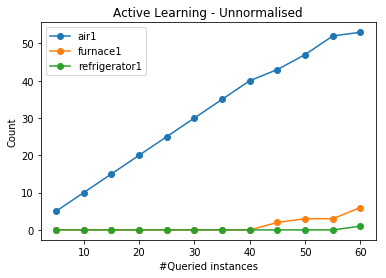

In [90]:
pd.DataFrame(r).T.fillna(0).plot(marker='o')
plt.xlabel("#Queried instances")
plt.ylabel("Count")
plt.title("Active Learning - Unnormalised")
plt.savefig("active-un-normalised-instances.pdf")
plt.savefig("active-un-normalised-instances.png")

In [29]:
random_error = {}
for seed in range(10):
    random_error[seed] = {}
    for month in range(13, 24):
        random_error[seed][month] = (pd.DataFrame(pred_df_random[seed][month])-pd.DataFrame(gt_df[month])).abs().mean()
active_error = {}
for month in range(13, 24):
    active_error[month] = (pd.DataFrame(pred_df_active[month])-pd.DataFrame(gt_df[month])).abs().mean()

In [30]:
p = pd.Panel(random_error)

/Users/nipun/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  exec(code_obj, self.user_global_ns, self.user_ns)


In [31]:
p.mean(axis=0)

,13,14,15,16,17,18,19,20,21,22,23
0,183.670635,98.917040,103.599180,109.230793,146.510105,228.494647,225.766548,215.866525,204.571799,175.320505,114.839979
1,7.811057,5.804199,6.229651,5.912853,5.117927,6.551906,6.971654,6.893011,7.344239,5.734851,6.837176
2,32.335948,35.308175,37.387902,39.924423,41.995060,47.236499,43.280655,31.456751,36.459670,39.779493,41.975639
3,131.094942,70.892487,83.144628,100.953300,98.668901,118.452101,129.403281,118.537058,103.589088,77.435366,75.881807
4,9.470271,11.311344,10.210851,11.198376,11.902710,11.364654,10.242584,8.974480,9.286529,9.469338,8.304415
5,11.046384,7.479038,7.108722,8.756453,6.221555,7.527238,7.875165,7.506683,7.380629,6.623077,6.081979
6,40.732903,40.327411,43.883903,42.364569,44.693420,48.045763,48.454866,43.227951,45.043545,41.361355,38.472116


In [32]:
pd.DataFrame(active_error)

,13,14,15,16,17,18,19,20,21,22,23
0,152.258418,76.224302,85.655452,101.769665,134.245330,274.142928,407.013512,378.049641,252.025111,93.126653,64.700532
1,6.080619,5.611081,6.413966,7.096044,5.567138,7.277045,9.561843,6.704303,6.568486,5.478696,6.703824
2,33.036321,41.365646,38.297595,35.201759,45.548907,52.107485,80.267836,33.433942,32.240552,42.085818,38.398600
3,129.188098,78.547688,90.456214,89.632751,99.372287,122.440204,152.790654,130.318364,115.620044,91.159202,75.648467
4,9.537927,11.494335,10.291448,10.771157,11.957500,11.787887,10.531045,9.164114,8.879074,8.484131,7.868910
5,9.871522,7.357884,7.031624,8.887989,6.002609,6.902167,7.488051,7.280617,6.898715,6.348403,5.756865
6,40.826921,42.099976,46.932691,38.942373,45.004280,48.713153,38.722135,43.727498,39.930769,39.650026,34.530877


In [ ]:
pd.DataFrame(active_error)

In [33]:
pd.DataFrame(active_error).to_csv("active-unnormalised.csv")

In [ ]:
fig, ax = plt.subplots(ncols=6, figsize=(30, 3))
for u, appliance in enumerate(APPLIANCE_ORDER[1:]):
    appliance_num = APPLIANCE_ORDER.index(appliance)-1
    re = p.mean(axis=0).iloc[appliance_num]
    ac = pd.DataFrame(active_error).iloc[appliance_num]
    pd.DataFrame({"Random":re, "Active":ac}).plot(kind='bar',ax=ax[u], title=appliance,
                                                  yerr =[p.std(axis=0).iloc[appliance_num], np.zeros_like(ac) ], rot=0)
fig.text(0.5, 0, "Month")
ax[0].set_ylabel("MAE \nLower is better")
plt.savefig("comparison-active.pdf")
plt.savefig("comparison-active.png")

In [ ]:
from IPython.display import Image
Image('comparison-active.png')

In [ ]:
chosen_homes = {12:[(5357, 'refrigerator1'), (5357, 'dishwasher1'), (4336, 'kitchenapp1'), (4336, 'air1'), (5357, 'microwave1')],
               13:[(3916, 'air1'), (7016, 'furnace1'), (5357, 'kitchenapp1'), (7719, 'refrigerator1'), (4154, 'air1')],
               14:[(2365, 'refrigerator1'), (4375, 'microwave1'), (2365, 'furnace1'), (7719, 'air1'), (4375, 'kitchenapp1')],
               15:[(1700, 'dishwasher1'), (7719, 'furnace1'), (1700, 'microwave1'), (3918, 'furnace1'), (3918, 'kitchenapp1')],
               16: [(1700, 'kitchenapp1'), (5357, 'air1'), (7719, 'dishwasher1'), (2018, 'air1'), (5357, 'furnace1')],
               17: [(7719, 'microwave1'), (2365, 'air1'), (484, 'dishwasher1'), (3044, 'kitchenapp1'), (1790, 'kitchenapp1')],
               18:[(2018, 'dishwasher1'), (7016, 'refrigerator1'), (4957, 'refrigerator1'), (4375, 'refrigerator1'), (3039, 'dishwasher1')],
               19:[(5972, 'refrigerator1'), (5972, 'air1'), (484, 'refrigerator1'), (6691, 'microwave1'), (484, 'air1')],
               20:[(3039, 'furnace1'), (1507, 'kitchenapp1'), (7719, 'kitchenapp1'), (7793, 'furnace1'), (6691, 'kitchenapp1')],
               21:[(4154, 'kitchenapp1'), (3916, 'kitchenapp1'), (3918, 'air1'), (3039, 'kitchenapp1'), (1790, 'air1')],
               22:[(7016, 'air1'), (1507, 'air1'), (3039, 'refrigerator1'), (4767, 'air1'), (1700, 'furnace1')],
               23:[(2018, 'refrigerator1'), (7793, 'refrigerator1'), (5972, 'furnace1'), (3044, 'refrigerator1'), (3039, 'air1')]}

In [ ]:
homes = chosen_homes[x][

In [ ]:
pd.Series([x[0] for x in chosen_homes[12]]).value_counts()

In [ ]:
all_homes = np.array([[x[0] for x in chosen_homes[m]] for m in range(13, 24)]).flatten()

In [ ]:
pd.Series(all_homes).value_counts().plot(kind='bar')

In [ ]:
np.searchsorted(use_homes, 7719)

In [ ]:
pd.DataFrame(t[152, :, :]).iloc[2].plot()

In [ ]:
p_m_h[13]

In [ ]:
{x:len(p_m_h[x]) for x in p_m_h.keys()}


In [ ]:
np.isfinite(t[:, 2:, -1].flatten()).sum()

In [ ]:
p_m_h = {}
for month in range(23, 24):
    p_m_h[month] = []
    for home in pool_homes:
        print(home)
        for i, appliance in enumerate(APPLIANCE_ORDER[1:]):
            pool_home_index  = np.searchsorted(use_homes, home)
            if np.isfinite(t[pool_home_index, i+1, month]):
                p_m_h[month].append((home, appliance))

In [ ]:
len(pool_homes)

In [ ]:
pool_home_index

In [ ]:
np.searchsorted(use_homes, 8084)

In [ ]:
np.isfinite(t[pool_home_index, i+1, month])

In [ ]:
t[169, 1].shape

In [ ]:
np.isfinite(t[169].flatten()).sum()

In [ ]:
p_m_h

In [38]:
pd.DataFrame(pred_df_active[12]).mean()

0    156.592713
1     10.070874
2     87.925745
3     94.152644
4     11.543699
5     22.071007
6     62.236536
dtype: float64

In [43]:
pd.DataFrame(gt_df[12]).mean()

0     37.301474
1      8.060328
2     64.479683
3    132.628646
4     15.752831
5     10.173254
6     70.073991
dtype: float64

air1 13 48.58249783562496 178.6686782058828
clotheswasher1 13 9.608862833543258 7.820350044602082
drye1 13 69.78013777732849 75.2647921104297
furnace1 13 177.67831329677415 91.5357952556608
kitchenapp1 13 14.564191335288342 11.779924733867226
microwave1 13 11.733154101805253 23.36606495065769
refrigerator1 13 71.74463111287656 39.814467988435254
air1 14 70.21329798448654 106.11559930892928
clotheswasher1 14 8.503025683489712 6.2772240018507945
drye1 14 71.25271752476692 88.34319056874551
furnace1 14 104.0522971590576 117.59001154020525
kitchenapp1 14 14.314557125791907 6.972923196824538
microwave1 14 11.53787426515059 9.92463953777502
refrigerator1 14 74.72334515674609 63.36294767101081
air1 15 127.62590723741671 140.7468935422133
clotheswasher1 15 8.388936590064656 6.711492302250985
drye1 15 75.86542469263077 78.2255646909935
furnace1 15 91.74045358403869 121.7940396391551
kitchenapp1 15 12.583809259696864 7.639016563740452
microwave1 15 10.743097977204757 10.14655017656169
refrigerat

Text(0.5,1,'Active-UnNormalised-vs-GT')

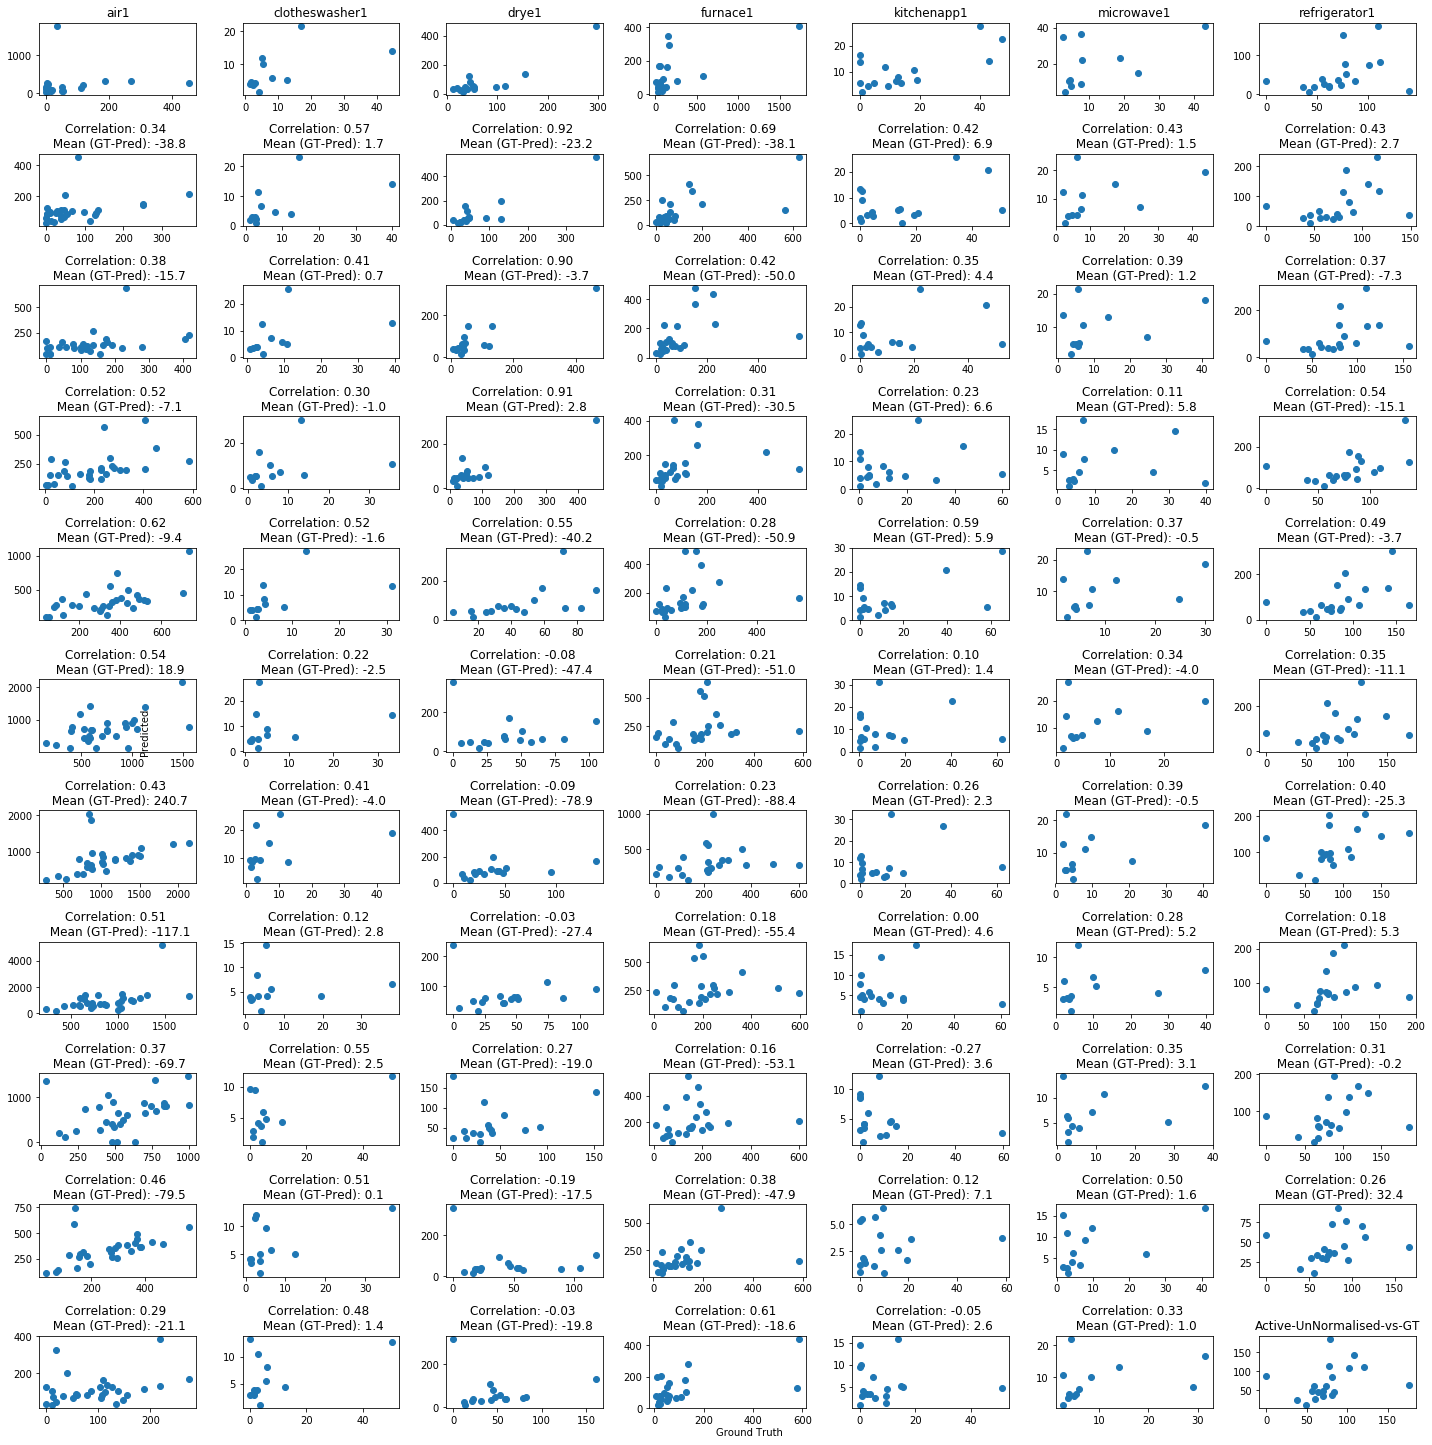

In [87]:
fig, ax = plt.subplots(ncols=len(APPLIANCE_ORDER)-1, figsize=(20, 20), nrows=11)
for m, month in enumerate(range(13, 24)):
    for appliance_num, appliance in enumerate(APPLIANCE_ORDER[1:]):
        ax[m][appliance_num].scatter(pd.DataFrame(gt_df[month])[appliance_num], pd.DataFrame(pred_df_active[month])[appliance_num])
        ax[0][appliance_num].set_title(appliance)
        
        e = pd.DataFrame({"gt":pd.DataFrame(gt_df[month])[appliance_num], "pred":pd.DataFrame(pred_df_active[month])[appliance_num]})
        ax[m][appliance_num].set_title("Correlation: {:0.2f} \n Mean (GT-Pred): {:0.1f}".format(e.corr().values[0, 1], 
                                                                                               (e['gt']-e['pred']).mean()))
        print(appliance, month, e['gt'].mean(), e['pred'].mean())
fig.text(0.5, 0, "Ground Truth")
fig.text(0.1, 0.5, "Predicted", rotation=90)
plt.tight_layout()
plt.title("Active-UnNormalised-vs-GT")

In [82]:
e.corr().values[0, 1]

0.14500540966852235

In [88]:
pd.concat([pd.DataFrame(pred_df_active[x]).mean() for x in range(12, 24)], axis=1).mean(axis=1)

0    392.519740
1      7.396829
2     77.268749
3    157.275240
4      7.562127
5     10.829002
6     69.330443
dtype: float64

In [95]:
pd.DataFrame(pred_df_active[12]).median()

0    77.757672
1     6.266622
2    53.314207
3    55.369576
4     6.961241
5    12.044290
6    37.519649
dtype: float64